# Welcome to the 2024 workshop!

Read carefully the instructions throughout this notebook. They will guide you in the realm of industry-level
anomaly detection problem. It will be instructive and (hopefully!) fun.

The initial cells are fully working and ready to be run. Try to understand what each cell does, comments can
help you during the process. Later on, there will be some parts that will require your intervention to work as
expected.

In [ ]:
# This cell can be ignored. It will be required in case you need to setup an environment from scratch
# (e.g. if you are using Colab).

# !pip install anomalib imgaug kornia lightning matplotlib 'numpy<=2.0.0' onnxruntime opencv-python pandas pillow scikit-learn torch torchvision timm FrEIA open-clip-torch

These are the "imports" for the notebook. You could see some warnings, but they are safe to ignore.
Simply run this cell and move on.

In [1]:
import random
from collections import defaultdict
from typing import Any, Dict, List, Tuple

import cv2
import lightning as L
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
from anomalib import TaskType
from anomalib.data import BTech, MVTec
from anomalib.data.utils import read_image
from anomalib.engine import Engine
from anomalib.metrics import F1AdaptiveThreshold, ManualThreshold
from anomalib.metrics.precision_recall_curve import BinaryPrecisionRecallCurve
from anomalib.models import Padim, Fastflow, Patchcore, Uflow
from anomalib.utils.post_processing import superimpose_anomaly_map, anomaly_map_to_color_map
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from matplotlib import pyplot as plt
from numpy.typing import NDArray
from PIL import Image
from torch import Tensor
from torchvision.transforms import ToPILImage
from torchmetrics import Metric

/usr/local/lib/python3.10/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
Could not find wandb. To use this feature, ensure that you have wandb installed.
OpenVINO is not installed. Please install OpenVINO to use OpenVINOInferencer.


## Dataset
The dataset we are going to work with is the so called "MVTec", which is the de facto battlefield for anomaly detection algorithms. The dataset is composed of several product categories coming from the industry.

Reference: https://www.mvtec.com/company/research/datasets/mvtec-ad

Optionally, BTech dataset (released by _beanTech_ and University of Udine) could also be used.

Reference https://ar5iv.labs.arxiv.org/html/2104.10036

The following cell initializes the dataset and their splits. In particular, it will download the whole dataset, it will extract and convert all the images and it will split the dataset in 3 distict groups (also called splits): _training_, _validation_ and _test_. It might require some time to complete. At the end you should see a "datasets" folder in your workspace directory with all the splits well organized.

In case you already have a preprocessed version of the MVTec dataset, copy it in `./dataset` folder. In this way you will avoid all the download and processin phase. At the end, you should have a similar file structure:
```
./dataset
  |-- MVTec
  :     |-- bottle
        |     |-- ground_truth
        |     |-- train
        |     `-- test
        |-- cable
        :     :
```

In [2]:
L.seed_everything(321)

datamodule = MVTec(
    category="cable",  # <--- We select only one category. Later you can replace this with others.
    image_size=(256, 256),
    train_batch_size=8,
    eval_batch_size=8,
    val_split_ratio=0.3,
    val_split_mode='from_test',
    test_split_ratio=0.3,
)
datamodule.prepare_data()  # <--- This line will download data, if necessary.
datamodule.setup()

# Ref: if you want to learn a bit more of the logic under the hood
# see here https://github.com/openvinotoolkit/anomalib/blob/2c2fac1a32cb2101262971a1991d625d15e61005/src/anomalib/data/base/datamodule.py#L51

Seed set to 321


### Dataset statistics

Dataset has been split into train/validation/test sets. Every sample in each
set is essentially composed of an RGB image and a binary mask (its label).

How many samples has dataset? How many of them are normal or defects?

Let's find out, by printing few statistics...

In [3]:
# Each 'sample' is a dictionary with the following keys: 'image_path', 'label', 'image', 'mask'.
# Label is `1` for anomalies and `0` for normal samples. 'image' and 'mask' are numpy arrays.

counter = 0
for sample_id in range(len(datamodule.train_data)):
    sample = datamodule.train_data[sample_id]
    if sample["label"] == 1:
        counter += 1
print(f"Training set: {counter}/{sample_id + 1} anomalous samples")

counter = 0
for sample_id in range(len(datamodule.val_data)):
    sample = datamodule.val_data[sample_id]
    if sample["label"] == 1:
        counter += 1
print(f"Validation set: {counter}/{sample_id + 1} anomalous samples")

counter = 0
for sample_id in range(len(datamodule.test_data)):
    sample = datamodule.test_data[sample_id]
    if sample["label"] == 1:
        counter += 1
print(f"Test set: {counter}/{sample_id + 1} anomalous samples")

Training set: 0/224 anomalous samples
Validation set: 27/44 anomalous samples
Test set: 65/106 anomalous samples


Note that the training set does *not* include anomalous samples. This is quite common in industry: defects
are usually rare, and hence hard to predict. In this exercise we can only count on the few anomalous samples
from the validation set to calibrate our model before testing it. 

### Look at the data!
Whenever it is possible, it is strongly recommended to look at the data with your own eyes in order to get a feeling
of the problem. The following functions will help you on this.

In [4]:
# The following functions will be used to plot image and label side by side.
# This cell can be run as it is.

def load_image_and_resize(image_path: str, size: Tuple[int, int]) -> NDArray:
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    height, width = size
    return cv2.resize(image, (width, height))

def show_image_and_mask(datamodule: L.LightningDataModule, index: int | None = None, split: str = "train"):
    if split.startswith("train"):
        dataset = datamodule.train_data
    elif split.startswith("val"):
        dataset = datamodule.val_data
    elif split.startswith("test"):
        dataset = datamodule.test_data
    else:
        raise ValueError("Unknown split")
    
    if index is None:
        index = random.choice(range(len(dataset)))
    sample = dataset[index]
    gt = sample["mask"]
    im = load_image_and_resize(sample["image_path"], gt.shape[-2:])
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(sample["image_path"], fontsize=10)
    ax[0].imshow(im)
    ax[0].axis("off")
    ax[0].set_title("image")
    ax[1].imshow(gt, interpolation='nearest')
    ax[1].axis("off")
    ax[1].set_title("label")
    plt.tight_layout()
    plt.show()

Get an idea of the dataset. Plot a random sample from the training set. Run the following cell multiple times to pick other "(_image_, _label_)" pairs. As you can see the training set is composed of normal samples only (i.e. label full o 0's).

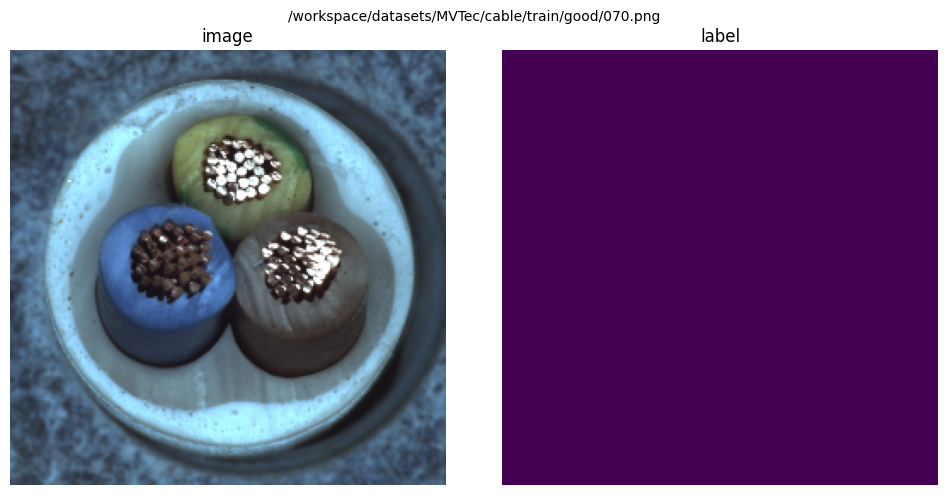

In [5]:
%matplotlib inline
show_image_and_mask(datamodule, split="train")

### EXERCISE
Run the previous cell by changing dataset split (e.g. "val"). Run it multiple times. Since the number of anomalous samples
is quite limited you could call the function `show_image_and_mask(...)` with the extra argument `index=XXX` in order to force
a specific sample id. Try to print the IDs of the anomalous samples of the validation set.

Anomalous sample IDs from validation set: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 38, 39, 40, 41, 42, 43]


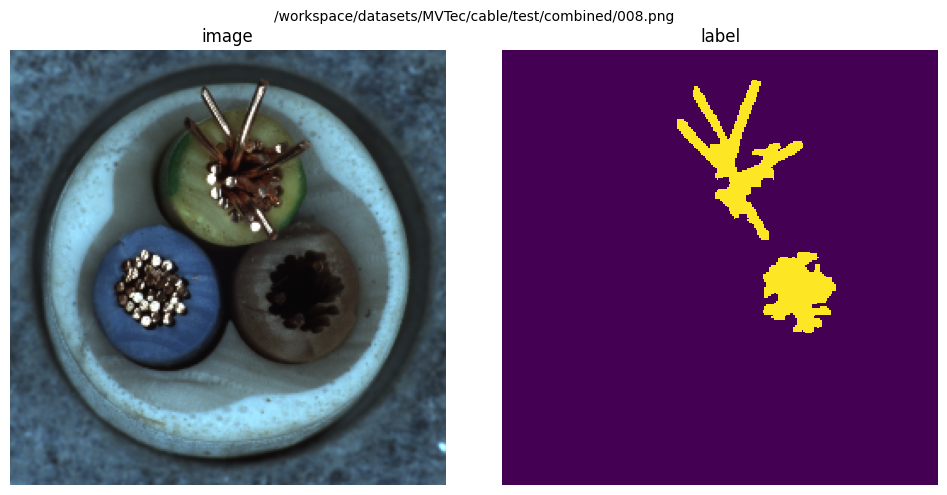

In [7]:
# Here few hints:
#  - Look at the function `show_image_and_mask` and see how it extracts the "sample" object.
#  - Try to iterate over the validation set keeping track of the IDs
#  - The mask of anomalous samples will have pixel greater than 0.

anomalous_ids = []
for sample_id in range(len(datamodule.val_data)):
    sample = datamodule.val_data[sample_id]
    if sample["label"] == 1:
        anomalous_ids.append(sample_id)
print(f"Anomalous sample IDs from validation set: {anomalous_ids}") 
    

%matplotlib inline
show_image_and_mask(datamodule, index=random.choice(anomalous_ids), split="val")

## Model

Define a model (for example Padim) and fit it on the training set.

Start by defining few classic metrics. They will be measured both image-wise and pixel-wise.

In [8]:
image_metrics = {
    "F1Score": {
        "class_path": "torchmetrics.classification.BinaryF1Score",
        "init_args": {},
    },
    "Precision": {
        "class_path": "torchmetrics.classification.BinaryPrecision",
        "init_args": {},
    },
    "Recall": {
        "class_path": "torchmetrics.classification.BinaryRecall",
        "init_args": {},
    },
}
pixel_metrics = image_metrics | {"PerRegionOverlap": {"class_path": "anomalib.metrics.PRO", "init_args": {}}}

Next, we are defining two important objects: the `model` (_Padim_ in this case) and the `engine`. The former is responsible of defining how features are extracted and classified, the latter is more a "runner" that invokes the model with the specific dataset and knows how to collect the results. Let's see them in action!

In [9]:
# This is a simple configuration for Padim. Later in this workshop we will try to change this a bit.
model = Padim(layers=["layer1"], n_features=64)

# For the `Engine` is enough to specify our metrics while letting all the other parameters are default.
engine = Engine(
    image_metrics=image_metrics,
    pixel_metrics=pixel_metrics,
)

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

The actual training process is called `fit`. In particular, a fitting loop is composed of a _training phase_ followed by a _validation phase_. Notice that we are passing the `datamodule` object and let the `engine` selecting for the required split in each sub-phase.

In [ ]:
engine.fit(model=model, datamodule=datamodule)

Now we are ready to inspect some predictions...

In [11]:
def plot_single_prediction(predictions: List[Dict], index: int) -> None:
    batch_size = len(predictions[0]['image'])
    batch_idx = index // batch_size
    sample_idx = index % batch_size
    
    image = load_image_and_resize(
        image_path=predictions[batch_idx]["image_path"][sample_idx],
        size=predictions[batch_idx]["anomaly_maps"][sample_idx].shape[-2:],
    )
    anomaly_map = predictions[batch_idx]["anomaly_maps"][sample_idx].permute(1, 2, 0).cpu().numpy()
    heat_map = superimpose_anomaly_map(anomaly_map=anomaly_map, image=image, normalize=True)
    pred_mask = predictions[batch_idx]["pred_masks"][sample_idx].permute(1, 2, 0).cpu().numpy()
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    fig.suptitle(predictions[batch_idx]["image_path"][sample_idx], fontsize=10)
    ax[0, 0].imshow(image)
    ax[0, 0].axis("off")
    ax[0, 0].set_title("image")
    ax[0, 1].imshow(anomaly_map)
    ax[0, 1].axis("off")
    ax[0, 1].set_title("anomaly map")
    ax[1, 0].imshow(heat_map)
    ax[1, 0].axis("off")
    ax[1, 0].set_title("heatmap")
    ax[1, 1].imshow(pred_mask, interpolation='nearest')
    ax[1, 1].axis("off")
    ax[1, 1].set_title("predicted mask")
    plt.tight_layout()
    plt.show()

In [12]:
# Note: `engine.predict()` will use the 'test' split from the datamodule, unless specified explicitly.
# Differently from the training and validation phase, `predict` does not compute metrics, but it will
# return more elaborated outputs.
predictions = engine.predict(model=model, datamodule=datamodule, return_predictions=True)

ckpt_path is not provided. Model weights will not be loaded.


Output()

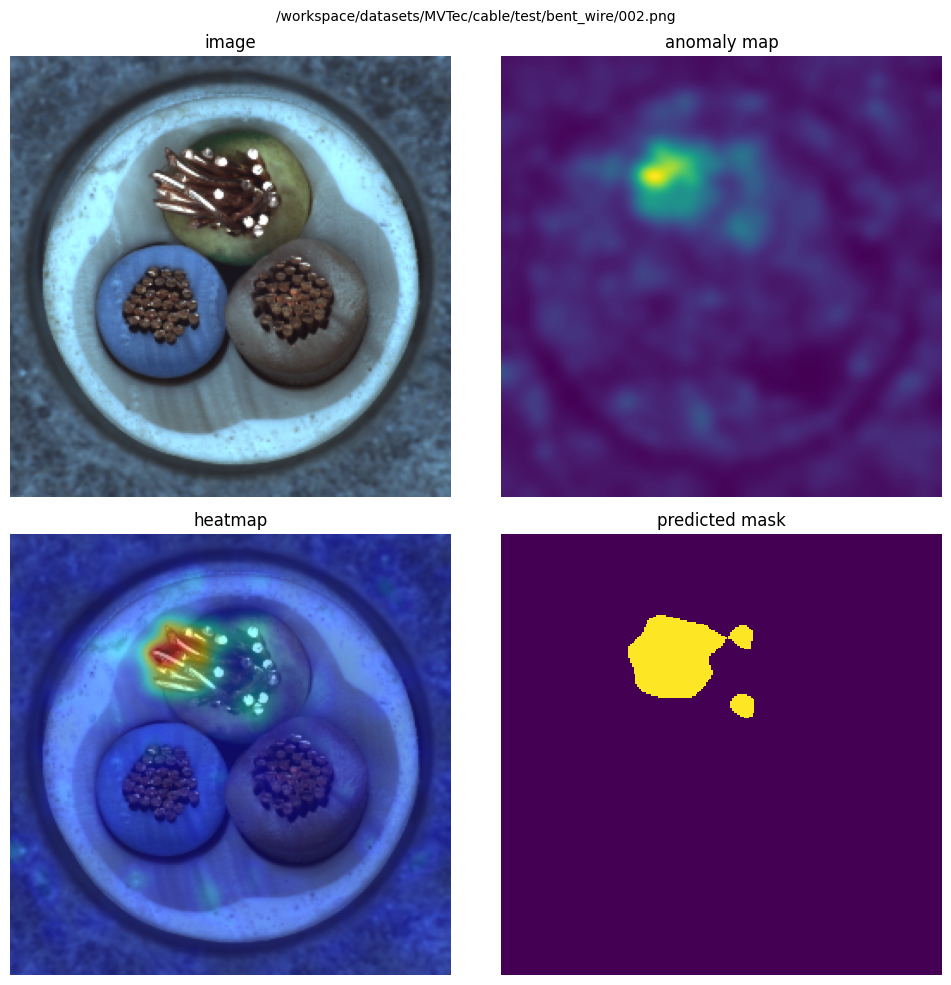

In [13]:
%matplotlib inline
plot_single_prediction(predictions, index=1)  # <-- Try to change the index and explore other outputs.

In [ ]:
# Note: `engine.test()` computes (and prints) the metrics.   
test_results = engine.test(model=model, datamodule=datamodule)

## Increase the depth of the backbone
Features are extracted from a pretrained backbone (in this case a Resnet18). As you may know, deep networks are composed of series of layers and each layer highlights a specific semanatic. We don't know in advance which of them work better in our problem, but we have the tools to find out.

In the following experiments we will classify the features collected at different layers and we will plot the respective metrics.

In [ ]:
results = defaultdict(list)

layer_groups = [["layer1"], ["layer2"], ["layer3"]]

# Fix the number of features (64) and increase the depth
L.seed_everything(42)
for layers in layer_groups:
    model = Padim(layers=layers, n_features=64)
    engine = Engine(
        image_metrics=image_metrics,
        pixel_metrics=pixel_metrics,
    )
    engine.fit(model=model, datamodule=datamodule)
    results_i = engine.test(model=model, datamodule=datamodule)
    for metric_name, metric_value in results_i[0].items():
        results[metric_name].append(metric_value)

In [15]:
def get_marker_style(metric: str) -> str:
    if "image" in metric:
        color = "r"
    elif "pixel" in metric:
        color = "b"
    else:
        color = "g"
    if "F1" in metric:
        shape = "s"
    elif "Precision" in metric:
        shape = "o"
    elif "Recall" in metric:
        shape = "^"
    else:
        shape = "*"
    return f"{color}{shape}--"

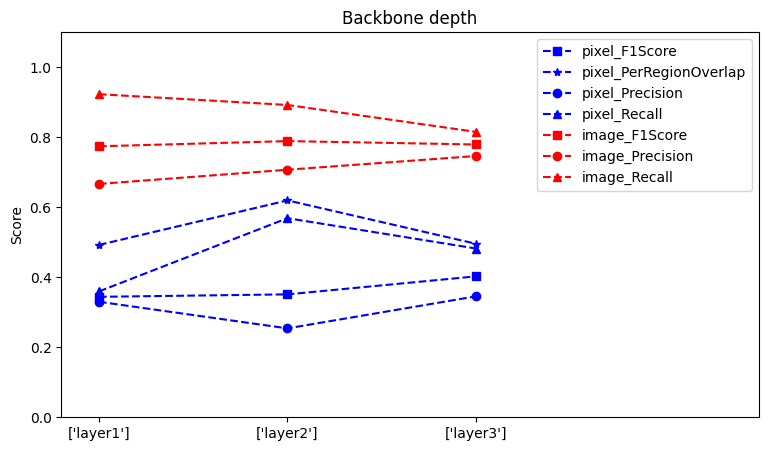

In [16]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(9,5))
xticks = np.arange(1, len(list(results.values())[0]) + 1) - 0.5
for metric, result in results.items():
    ax.plot(xticks, result, get_marker_style(metric),label=metric)
ax.axis((0.3, 4, 0., 1.1))
ax.set_title('Backbone depth')
ax.set_xticks(ticks=xticks, labels=[f"{layer_group}" for layer_group in layer_groups])
ax.set_ylabel('Score')
ax.legend(loc='upper right')
plt.show()

### EXERCISE
It does not seem to be a "clear winner" between features from _Layer1_, _Layer2_ or _Layer3_.

Try to run another experiment and use a subset of features extracted from both layers. Note that the argument `layers` takes a list of strings.

In [17]:
### SOLUTION
model = Padim(layers=["layer1", "layer2", "layer3"], n_features=64)
engine = Engine(
    image_metrics=image_metrics,
    pixel_metrics=pixel_metrics,
)
engine.fit(model=model, datamodule=datamodule)
_ = engine.test(model=model, datamodule=datamodule)

Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
/usr/local/lib/python3.10/site-packages/lightning/pytorch/core/optimizer.py:182: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer


┏━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name                  ┃ Type                     ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model                 │ PadimModel               │  2.8 M │ train │
│ 1 │ _transform            │ Compose                  │      0 │ train │
│ 2 │ normalization_metrics │ MetricCollection         │      0 │ train │
│ 3 │ image_threshold       │ F1AdaptiveThreshold      │      0 │ train │
│ 4 │ pixel_threshold       │ F1AdaptiveThreshold      │      0 │ train │
│ 5 │ image_metrics         │ AnomalibMetricCollection │      0 │ train │
│ 6 │ pixel_metrics         │ AnomalibMetricCollection │      0 │ train │
└───┴───────────────────────┴──────────────────────────┴────────┴───────┘

Trainable params: 2.8 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.8 M                                                                                                
Total estimated model params size (MB): 11                                                                         
Modules in train mode: 20                                                                                          
Modules in eval mode: 69

Output()

`Trainer.fit` stopped: `max_epochs=1` reached.


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       image_F1Score       │    0.7969924807548523     │
│      image_Precision      │     0.779411792755127     │
│       image_Recall        │    0.8153846263885498     │
│       pixel_F1Score       │    0.4131995141506195     │
│  pixel_PerRegionOverlap   │    0.3814249038696289     │
│      pixel_Precision      │    0.4371437430381775     │
│       pixel_Recall        │    0.39174211025238037    │
└───────────────────────────┴───────────────────────────┘

## Increase the number of features

The features extracted from the backbone are (randomly) reduced in number. We could argue that the more retained features, the higher the metrics. Let's verify this argument with a simple experiment.

### EXERCISE

In [19]:
########################### SOLUTION ##############################
_ = L.seed_everything(42)  # this is required for reproducibility of the random projection.

results = defaultdict(list)
n_features_sweep = [16, 32, 64, 128]
for n_features in n_features_sweep:
    model = Padim(layers=["layer1", "layer2"], n_features=n_features)
    engine = Engine(
        image_metrics=image_metrics,
        pixel_metrics=pixel_metrics,
    )
    engine.fit(model=model, datamodule=datamodule)
    results_i = engine.test(model=model, datamodule=datamodule)
    for metric_name, metric_value in results_i[0].items():
        results[metric_name].append(metric_value)

Seed set to 42
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


┏━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name                  ┃ Type                     ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model                 │ PadimModel               │  683 K │ train │
│ 1 │ _transform            │ Compose                  │      0 │ train │
│ 2 │ normalization_metrics │ MetricCollection         │      0 │ train │
│ 3 │ image_threshold       │ F1AdaptiveThreshold      │      0 │ train │
│ 4 │ pixel_threshold       │ F1AdaptiveThreshold      │      0 │ train │
│ 5 │ image_metrics         │ AnomalibMetricCollection │      0 │ train │
│ 6 │ pixel_metrics         │ AnomalibMetricCollection │      0 │ train │
└───┴───────────────────────┴──────────────────────────┴────────┴───────┘

Trainable params: 683 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 683 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 20                                                                                          
Modules in eval mode: 47

Output()

`Trainer.fit` stopped: `max_epochs=1` reached.


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       image_F1Score       │    0.7484662532806396     │
│      image_Precision      │    0.6224489808082581     │
│       image_Recall        │    0.9384615421295166     │
│       pixel_F1Score       │    0.17864982783794403    │
│  pixel_PerRegionOverlap   │    0.39762356877326965    │
│      pixel_Precision      │    0.1432265043258667     │
│       pixel_Recall        │    0.23735281825065613    │
└───────────────────────────┴───────────────────────────┘

Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


┏━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name                  ┃ Type                     ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model                 │ PadimModel               │  683 K │ train │
│ 1 │ _transform            │ Compose                  │      0 │ train │
│ 2 │ normalization_metrics │ MetricCollection         │      0 │ train │
│ 3 │ image_threshold       │ F1AdaptiveThreshold      │      0 │ train │
│ 4 │ pixel_threshold       │ F1AdaptiveThreshold      │      0 │ train │
│ 5 │ image_metrics         │ AnomalibMetricCollection │      0 │ train │
│ 6 │ pixel_metrics         │ AnomalibMetricCollection │      0 │ train │
└───┴───────────────────────┴──────────────────────────┴────────┴───────┘

Trainable params: 683 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 683 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 20                                                                                          
Modules in eval mode: 47

Output()

`Trainer.fit` stopped: `max_epochs=1` reached.


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       image_F1Score       │    0.7948718070983887     │
│      image_Precision      │    0.6813187003135681     │
│       image_Recall        │    0.9538461565971375     │
│       pixel_F1Score       │    0.2653407156467438     │
│  pixel_PerRegionOverlap   │    0.44058358669281006    │
│      pixel_Precision      │    0.24448156356811523    │
│       pixel_Recall        │    0.29009130597114563    │
└───────────────────────────┴───────────────────────────┘

Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


┏━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name                  ┃ Type                     ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model                 │ PadimModel               │  683 K │ train │
│ 1 │ _transform            │ Compose                  │      0 │ train │
│ 2 │ normalization_metrics │ MetricCollection         │      0 │ train │
│ 3 │ image_threshold       │ F1AdaptiveThreshold      │      0 │ train │
│ 4 │ pixel_threshold       │ F1AdaptiveThreshold      │      0 │ train │
│ 5 │ image_metrics         │ AnomalibMetricCollection │      0 │ train │
│ 6 │ pixel_metrics         │ AnomalibMetricCollection │      0 │ train │
└───┴───────────────────────┴──────────────────────────┴────────┴───────┘

Trainable params: 683 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 683 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 20                                                                                          
Modules in eval mode: 47

Output()

`Trainer.fit` stopped: `max_epochs=1` reached.


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       image_F1Score       │    0.8527131676673889     │
│      image_Precision      │         0.859375          │
│       image_Recall        │    0.8461538553237915     │
│       pixel_F1Score       │    0.4682808816432953     │
│  pixel_PerRegionOverlap   │     0.545775294303894     │
│      pixel_Precision      │    0.4064388871192932     │
│       pixel_Recall        │    0.5523194074630737     │
└───────────────────────────┴───────────────────────────┘

Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


┏━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name                  ┃ Type                     ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model                 │ PadimModel               │  683 K │ train │
│ 1 │ _transform            │ Compose                  │      0 │ train │
│ 2 │ normalization_metrics │ MetricCollection         │      0 │ train │
│ 3 │ image_threshold       │ F1AdaptiveThreshold      │      0 │ train │
│ 4 │ pixel_threshold       │ F1AdaptiveThreshold      │      0 │ train │
│ 5 │ image_metrics         │ AnomalibMetricCollection │      0 │ train │
│ 6 │ pixel_metrics         │ AnomalibMetricCollection │      0 │ train │
└───┴───────────────────────┴──────────────────────────┴────────┴───────┘

Trainable params: 683 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 683 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 20                                                                                          
Modules in eval mode: 47

Output()

`Trainer.fit` stopped: `max_epochs=1` reached.


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       image_F1Score       │    0.7916666865348816     │
│      image_Precision      │    0.7215189933776855     │
│       image_Recall        │    0.8769230842590332     │
│       pixel_F1Score       │    0.3431711196899414     │
│  pixel_PerRegionOverlap   │    0.6595366597175598     │
│      pixel_Precision      │    0.24265041947364807    │
│       pixel_Recall        │     0.585877537727356     │
└───────────────────────────┴───────────────────────────┘

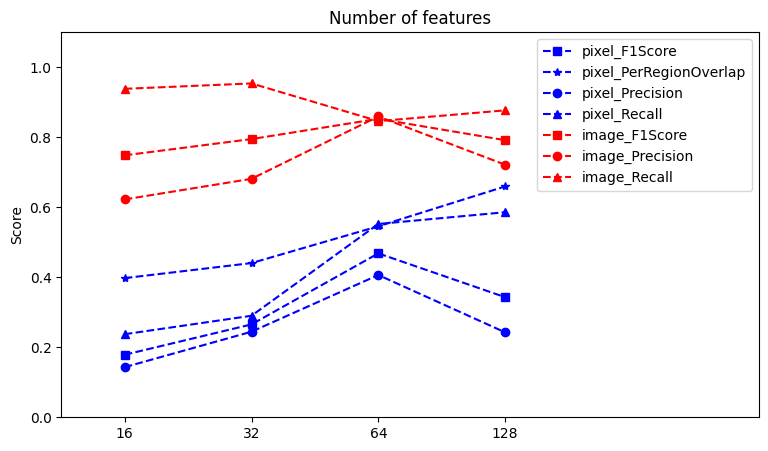

In [20]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(9,5))
xticks = np.arange(1, len(list(results.values())[0]) + 1) - 0.5
for metric, result in results.items():
    ax.plot(xticks, result, get_marker_style(metric),label=metric)
ax.axis((0, 5.5, 0., 1.1))
ax.set_title('Number of features')
ax.set_xticks(ticks=xticks, labels=n_features_sweep)
ax.set_ylabel('Score')
ax.legend(loc='upper right')
plt.show()

#####################################################################

### EXERCISE
Try to change the seed and check if results are different.

## Tuning the threshold

You might wonder how the threshold on the anomaly maps is chosen in order to produce a binary anomaly mask. By default, the _Engine_ selects the value that maximises the F1Score. This is how the validation set is used.

Let's check how well the model behaves on the validation set.

In [21]:
# Define a model, we'll keep this configuration throughout this section.
engine = Engine(image_metrics=image_metrics, pixel_metrics=[])
model = Padim(layers=["layer1"], n_features=64)

In [22]:
engine.fit(model, datamodule=datamodule)

Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
/usr/local/lib/python3.10/site-packages/lightning/pytorch/core/optimizer.py:182: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer


┏━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name                  ┃ Type                     ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model                 │ PadimModel               │  157 K │ train │
│ 1 │ _transform            │ Compose                  │      0 │ train │
│ 2 │ normalization_metrics │ MetricCollection         │      0 │ train │
│ 3 │ image_threshold       │ F1AdaptiveThreshold      │      0 │ train │
│ 4 │ pixel_threshold       │ F1AdaptiveThreshold      │      0 │ train │
│ 5 │ image_metrics         │ AnomalibMetricCollection │      0 │ train │
│ 6 │ pixel_metrics         │ AnomalibMetricCollection │      0 │ train │
└───┴───────────────────────┴──────────────────────────┴────────┴───────┘

Trainable params: 157 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 157 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 16                                                                                          
Modules in eval mode: 25

Output()

`Trainer.fit` stopped: `max_epochs=1` reached.


In [23]:
# Now test the fitted model against the validation set. Instead of feeding the `datamodule`,
# pass the validation dataloader explicitly.
_ = engine.test(model=model, dataloaders=[datamodule.test_dataloader()])

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       image_F1Score       │     0.774193525314331     │
│      image_Precision      │    0.6666666865348816     │
│       image_Recall        │    0.9230769276618958     │
└───────────────────────────┴───────────────────────────┘

If you've used the default settings for the dataset and the model you will notice an image-wise recall of **~92%**, which translates into 2 missed anomalous samples (i.e. false-negatives) out of the 27 included in the validation set.

In the real world, depending on use cases this choice might not be ideal. For instance, sometimes you prefer to sacrifice false-positives in order to reduce the number of missed anomalies.

### EXERCISE
Find the (highest) threshold for which the image-wise recall on the validation set > 95%.

In [24]:
# Idea:
#  - let's use a PR curve in order to take the threshold that satisfies the requirement.
#  - Write a custom `Threshold` policy

# You can start from this skeleton class and fill the missing part

class MyThreshold(BinaryPrecisionRecallCurve, ManualThreshold):
    def __init__(self, default_value: float = 0.5, **kwargs) -> None:
        super().__init__(**kwargs)
        self.add_state("value", default=torch.tensor(default_value), persistent=True)
        self.value = torch.tensor(default_value)

    def compute(self) -> torch.Tensor:
        """Compute the threshold.
        
        Store the threshold into `self.value` and return it
        """
        precision: torch.Tensor
        recall: torch.Tensor
        thresholds: torch.Tensor
        precision, recall, thresholds = super().compute()  # <-- use these!

        #######################
        # POSSIBLE SOLUTION
        # `recall` is a tensor of the kind [1.0, 1.0, 0.99..., ..., 0.001, 0.0]
        # `thresholds` is a tensor of [th1, th2, th3, ...], with th1 < th2 < th3...
        # `recall > target` will produce [1, 1, 1, ..., 0, 0, ...]
        # The threshold that produces to the right-most `1` is the `argmin - 2` since
        # `thresholds` is 1 element shorter than precision/recall tensors.
        target = 0.95
        
        best_idx = torch.argmin((recall > target).to(torch.int)) - 2
        self.value = thresholds[best_idx]
        return self.value
        #######################

    def __repr__(self) -> str:
        return f"{super().__repr__()} (value={self.value:.2f})"

In [25]:
# Verify custom threshold, pass it explicitly to the `Engine`.
engine = Engine(
    threshold=MyThreshold(),
    image_metrics=image_metrics,
    pixel_metrics=[],
)
model = Padim(layers=["layer1"], n_features=64)
engine.fit(model=model, datamodule=datamodule)

Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


┏━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name                  ┃ Type                     ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model                 │ PadimModel               │  157 K │ train │
│ 1 │ _transform            │ Compose                  │      0 │ train │
│ 2 │ normalization_metrics │ MetricCollection         │      0 │ train │
│ 3 │ image_threshold       │ MyThreshold              │      0 │ train │
│ 4 │ pixel_threshold       │ MyThreshold              │      0 │ train │
│ 5 │ image_metrics         │ AnomalibMetricCollection │      0 │ train │
│ 6 │ pixel_metrics         │ AnomalibMetricCollection │      0 │ train │
└───┴───────────────────────┴──────────────────────────┴────────┴───────┘

Trainable params: 157 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 157 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 16                                                                                          
Modules in eval mode: 25

Output()

`Trainer.fit` stopped: `max_epochs=1` reached.


In [26]:
metrics_val = engine.test(model=model, dataloaders=[datamodule.val_dataloader()])

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       image_F1Score       │    0.8387096524238586     │
│      image_Precision      │    0.7428571581840515     │
│       image_Recall        │    0.9629629850387573     │
└───────────────────────────┴───────────────────────────┘

Let's see how metrics have changed on the test set.

In [27]:
_ = engine.test(model=model, dataloaders=[datamodule.test_dataloader()])

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       image_F1Score       │     0.774193525314331     │
│      image_Precision      │    0.6666666865348816     │
│       image_Recall        │    0.9230769276618958     │
└───────────────────────────┴───────────────────────────┘

## Cherry picking

As already stated above, it is very important to always pair numbers with visual inspection. A common practice in data-science is to manually select few examples where the model behaves particularly well or where it struggles the most. This process is called "[_cherry-picking_](https://en.wikipedia.org/wiki/Cherry_picking)".

### EXERCISE
Try to identify the missed anomalous samples from the test set and plot their anomaly maps.

In [28]:
### ONE POSSIBLE SOLUTION
def plot_single_prediction_with_gt(gt, predictions: List[Dict], index: int, threshold: float = 0.5) -> None:
    batch_size = len(predictions[0]['image'])
    batch_idx = index // batch_size
    sample_idx = index % batch_size
    
    image = load_image_and_resize(
        image_path=predictions[batch_idx]["image_path"][sample_idx],
        size=predictions[batch_idx]["anomaly_maps"][sample_idx].shape[-2:],
    )
    anomaly_map = predictions[batch_idx]["anomaly_maps"][sample_idx].permute(1, 2, 0).cpu().numpy()
    pred_mask = anomaly_map > threshold
    fig, ax = plt.subplots(2, 2, figsize=(9, 9))
    fig.suptitle(predictions[batch_idx]["image_path"][sample_idx], fontsize=10)
    ax[0, 0].imshow(image)
    ax[0, 0].axis("off")
    ax[0, 0].set_title("image")
    ax[0, 1].imshow(gt.cpu().numpy(), interpolation='nearest')
    ax[0, 1].axis("off")
    ax[0, 1].set_title("label")
    ax[1, 0].imshow(anomaly_map)
    ax[1, 0].axis("off")
    ax[1, 0].set_title("anomaly map")
    ax[1, 1].imshow(pred_mask, interpolation='nearest')
    ax[1, 1].axis("off")
    ax[1, 1].set_title(f"mask after threshold of {threshold:.2f}")
    plt.tight_layout()
    plt.show()

In [29]:
predictions = engine.predict(model=model, datamodule=datamodule, return_predictions=True)

ckpt_path is not provided. Model weights will not be loaded.


Output()

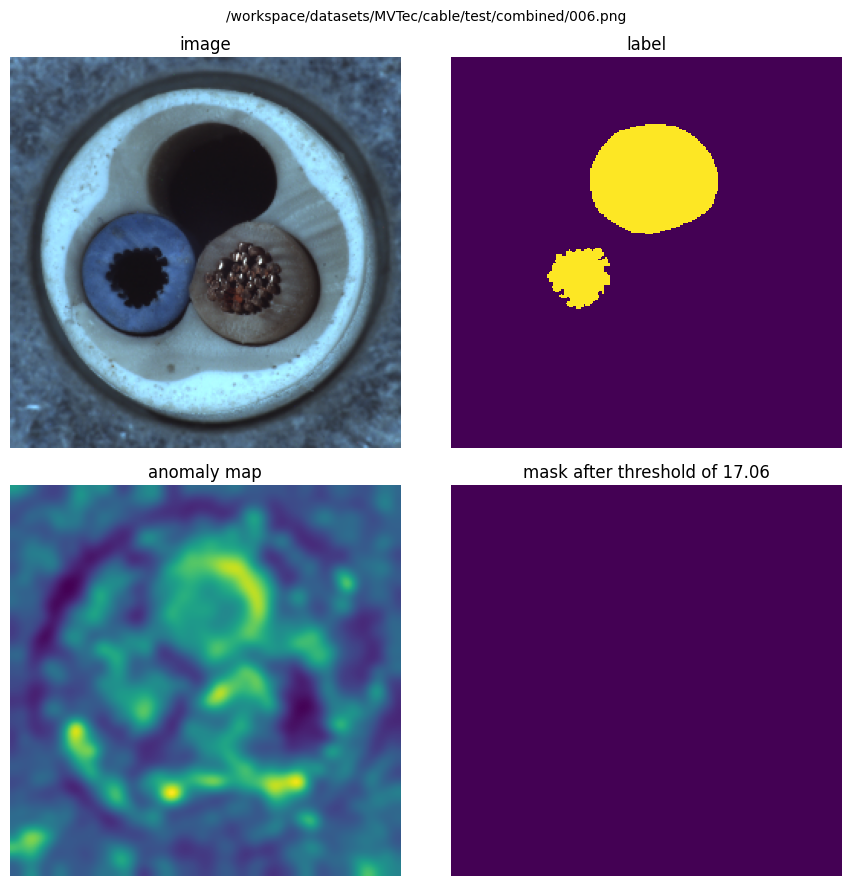

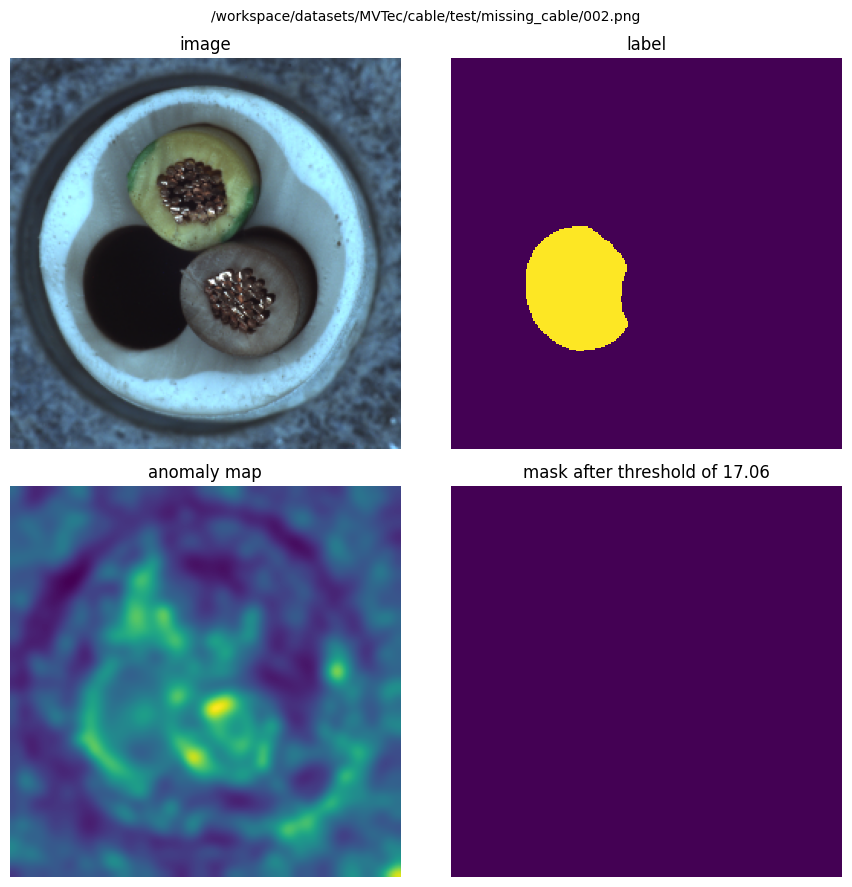

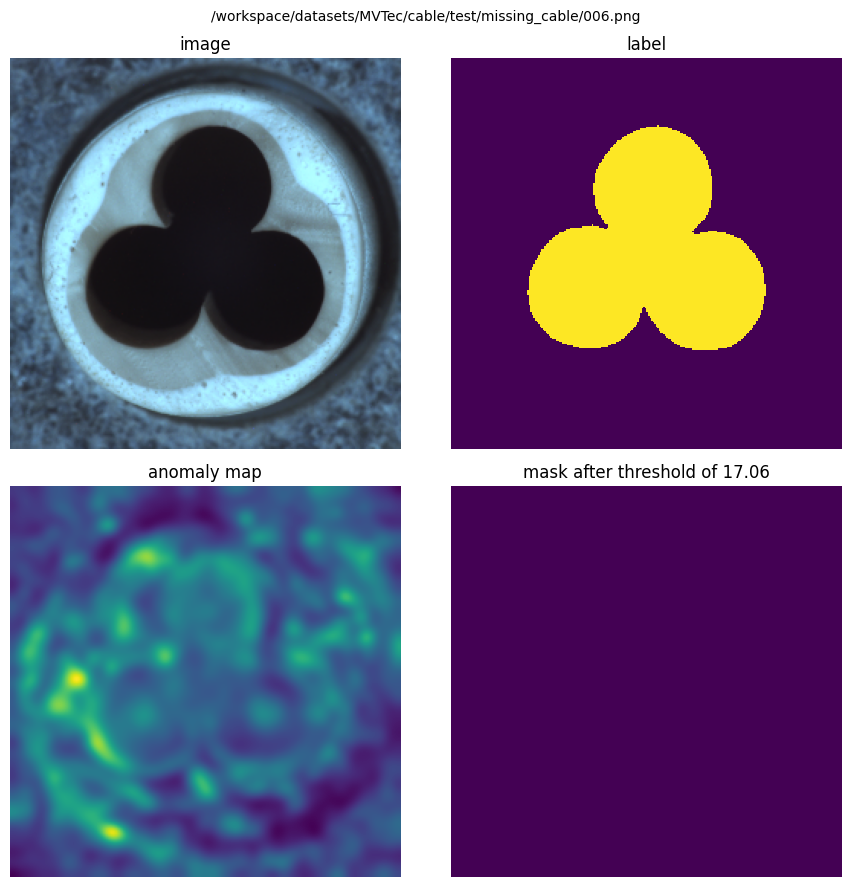

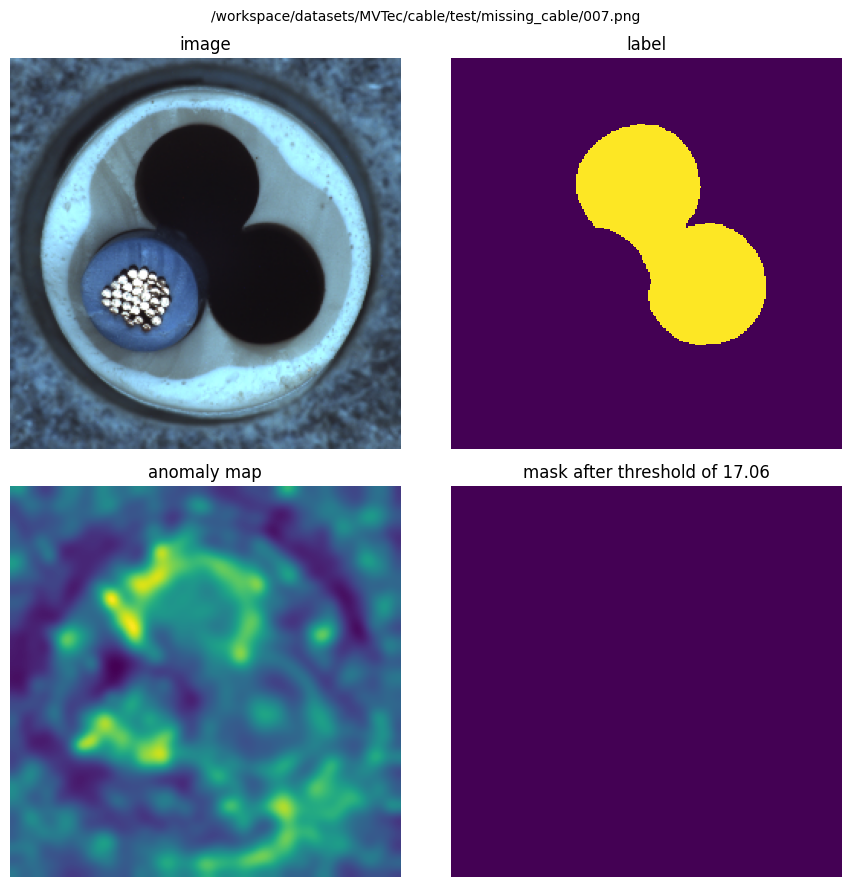

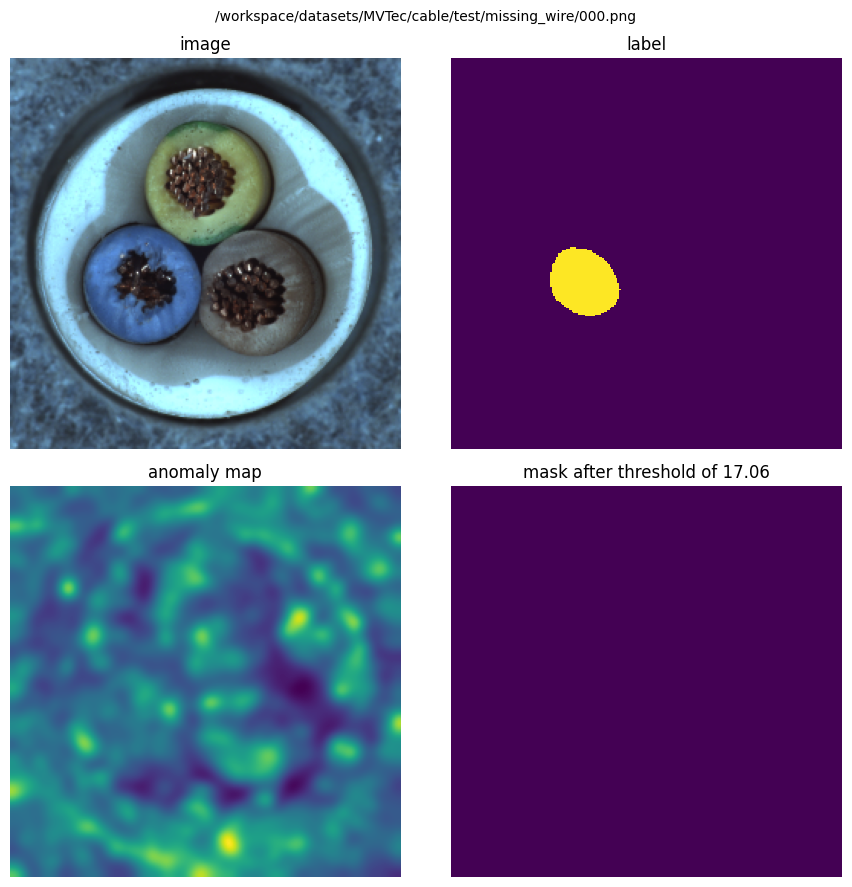

In [30]:
%matplotlib inline

batch_size = len(predictions[0]['image'])
for sample_idx in range(len(datamodule.test_data)):
    label = datamodule.test_data[sample_idx]['label']
    gt = datamodule.test_data[sample_idx]['mask']
    batch_idx = sample_idx // batch_size
    sample_in_batch_idx = sample_idx % batch_size
    pred = predictions[batch_idx]['pred_labels'][sample_in_batch_idx]
    if label > 0 and pred == 0:
        plot_single_prediction_with_gt(gt, predictions, index=sample_idx, threshold=model.image_threshold.value.cpu().numpy())

## Changing the model: what about PatchCore?

Reference: https://www.amazon.science/publications/towards-total-recall-in-industrial-anomaly-detection

In [32]:
engine = Engine(
    image_metrics=image_metrics,
    pixel_metrics=pixel_metrics,
)
pc = Patchcore(backbone="resnet18", layers=["layer3"], coreset_sampling_ratio=0.1)

In [ ]:
engine.fit(model=pc, datamodule=datamodule)

In [37]:
_ = engine.test(model=pc, datamodule=datamodule)

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       image_F1Score       │     0.939393937587738     │
│      image_Precision      │    0.9253731369972229     │
│       image_Recall        │    0.9538461565971375     │
│       pixel_F1Score       │    0.5775017142295837     │
│  pixel_PerRegionOverlap   │    0.5148948431015015     │
│      pixel_Precision      │    0.5623390674591064     │
│       pixel_Recall        │    0.5935047268867493     │
└───────────────────────────┴───────────────────────────┘

### EXERCISE
Try with different size of the "coreset" (10% and 1%)

In [ ]:
engine = Engine(
    image_metrics=image_metrics,
    pixel_metrics=pixel_metrics,
)
pc = Patchcore(backbone="resnet18", layers=["layer3"], coreset_sampling_ratio=0.01)
engine.fit(model=pc, datamodule=datamodule)

In [39]:
_ = engine.test(model=pc, datamodule=datamodule)

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       image_F1Score       │     0.89552241563797      │
│      image_Precision      │    0.8695651888847351     │
│       image_Recall        │    0.9230769276618958     │
│       pixel_F1Score       │    0.5527583360671997     │
│  pixel_PerRegionOverlap   │    0.4610157907009125     │
│      pixel_Precision      │    0.5580272078514099     │
│       pixel_Recall        │    0.5475879907608032     │
└───────────────────────────┴───────────────────────────┘

## Changing the model: what about FastFlow?

Reference: https://arxiv.org/pdf/2111.07677

In [ ]:
engine = Engine(
    image_metrics=image_metrics,
    pixel_metrics=pixel_metrics,
    max_epochs=1,
    check_val_every_n_epoch=None,
)
ff = Fastflow()
engine.fit(model=ff, datamodule=datamodule)

In [43]:
_ = engine.test(model=ff, datamodule=datamodule)

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       image_F1Score       │    0.7672955989837646     │
│      image_Precision      │    0.6489361524581909     │
│       image_Recall        │    0.9384615421295166     │
│       pixel_F1Score       │     0.34481281042099      │
│  pixel_PerRegionOverlap   │    0.5554242134094238     │
│      pixel_Precision      │    0.27930188179016113    │
│       pixel_Recall        │    0.4504720866680145     │
└───────────────────────────┴───────────────────────────┘

Please note that the _engine_ has been configured to fit for one "epoch" only. It means that model parameters has been "adjusted" of a tiny amount to match the training set only once (actually, for a number of steps that fed the training samples only once). In this case, the pretrained model used as a starting point was sufficiently general purpose to be adequate enough for our dataset. However, we could constrain the model to adhere (i.e. _fit_) our training dataset even more (hence trading its generality in for some specialization). This can be obtained by extending the training time with more epochs.

### EXERCISE
Increment the number of number of epochs (up to 10, 20 or even more). Don't raise this value too much since it will require some time to complete. After each experiment, keep track of the metrics in a dictionary and plot them a graph. 

In [ ]:
metrics = {"val": defaultdict(list), "test": defaultdict(list)}
for n_epochs in [1, 2, 4, 7, 12, 24, 50]:
    engine = Engine(
        image_metrics=image_metrics,
        pixel_metrics=pixel_metrics,
        max_epochs=n_epochs,
        check_val_every_n_epoch=None,
    )
    ff = Fastflow()
    engine.fit(model=ff, datamodule=datamodule)
    metrics_i = engine.test(model=ff, datamodule=datamodule)[0]
    for m_name, m_value in metrics_i.items():
        metrics["test"][m_name].append(m_value)
    metrics_i = engine.test(model=ff, dataloaders=[datamodule.val_dataloader()])[0]
    for m_name, m_value in metrics_i.items():
        metrics["val"][m_name].append(m_value)

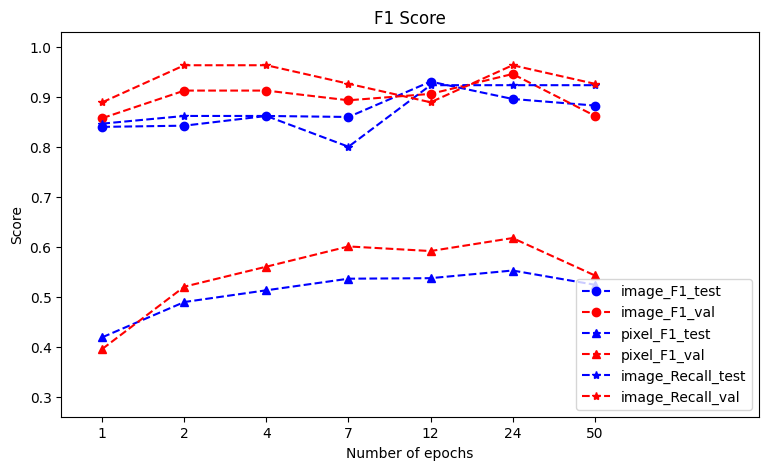

In [46]:
%matplotlib inline

n_epochs = [1, 2, 4, 7, 12, 24, 50]
fig, ax = plt.subplots(figsize=(9,5))
xticks = np.arange(1, len(n_epochs) + 1) - 0.5
# for split, metrics_per_split in results.items():
#     ax.plot(xticks, result, get_marker_style(metric),label=metric)
ax.plot(xticks, metrics['test']['image_F1Score'], "ob--", label="image_F1_test")
ax.plot(xticks, metrics['val']['image_F1Score'], "or--", label="image_F1_val")
ax.plot(xticks, metrics['test']['pixel_F1Score'], "^b--", label="pixel_F1_test")
ax.plot(xticks, metrics['val']['pixel_F1Score'], "^r--", label="pixel_F1_val")
ax.plot(xticks, metrics['test']['image_Recall'], "*b--", label="image_Recall_test")
ax.plot(xticks, metrics['val']['image_Recall'], "*r--", label="image_Recall_val")
ax.axis((0, 8.5, 0.26, 1.03))
ax.set_title('F1 Score')
ax.set_xticks(ticks=xticks, labels=[f"{i}" for i in n_epochs])
ax.set_xlabel("Number of epochs")
ax.set_ylabel('Score')
ax.legend(loc='lower right')
plt.show()

### EXERCISE
Take the model that has the highest recall image-wise and check which are the hardest samples to identify by plotting their anomaly mask.

In [47]:
predictions = engine.predict(model=ff, datamodule=datamodule, return_predictions=True)

ckpt_path is not provided. Model weights will not be loaded.


Output()

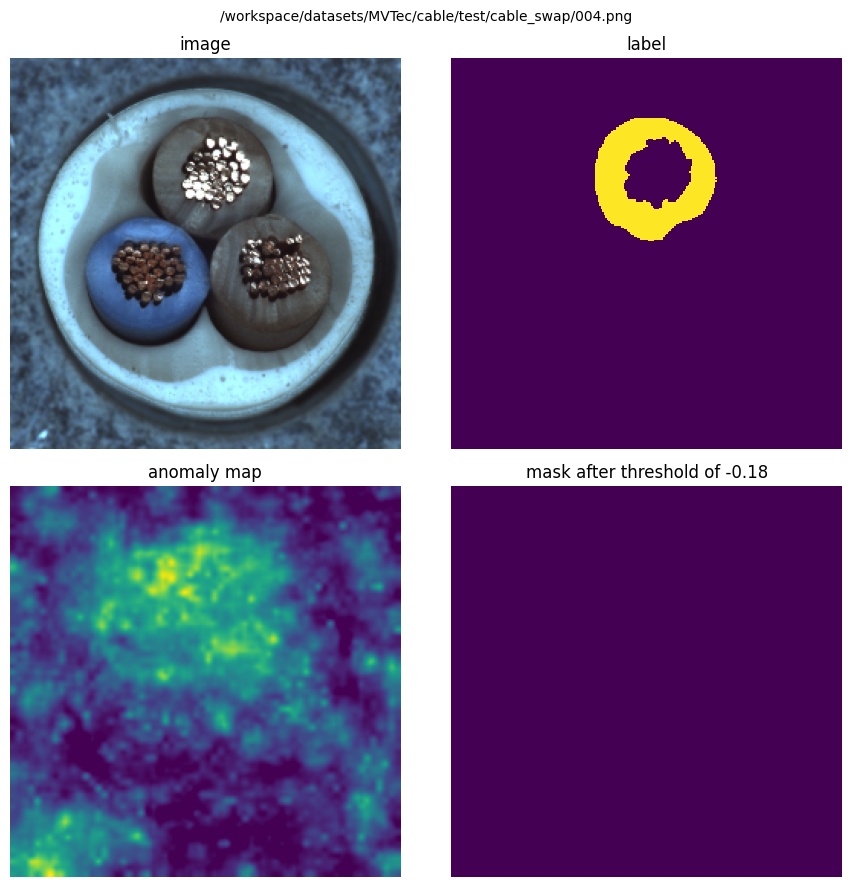

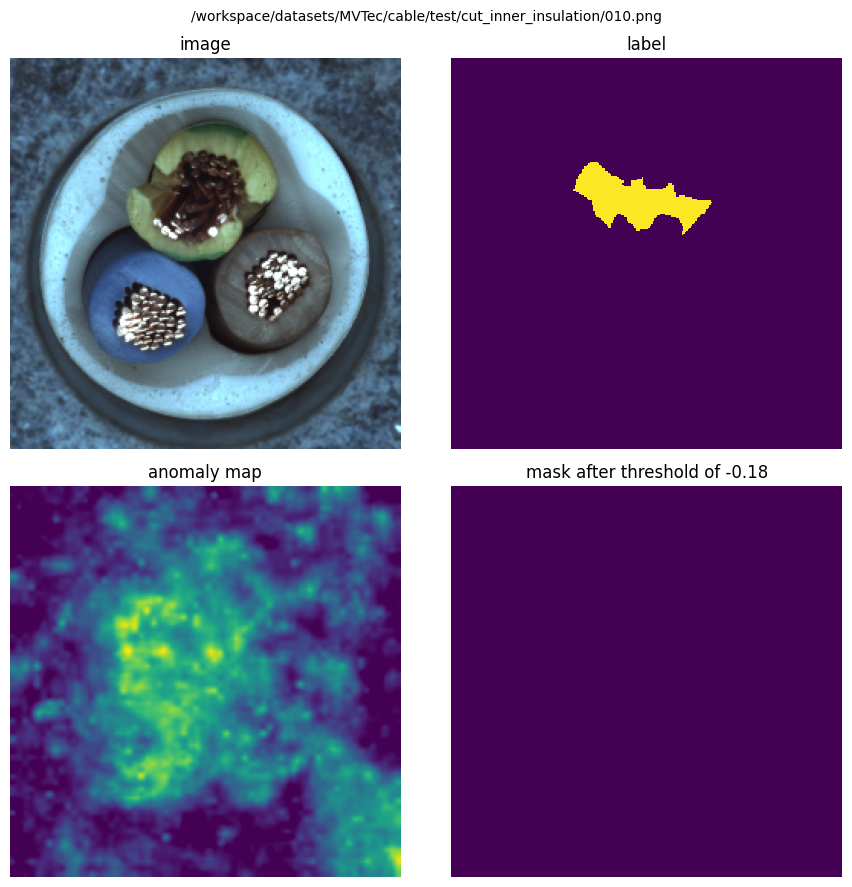

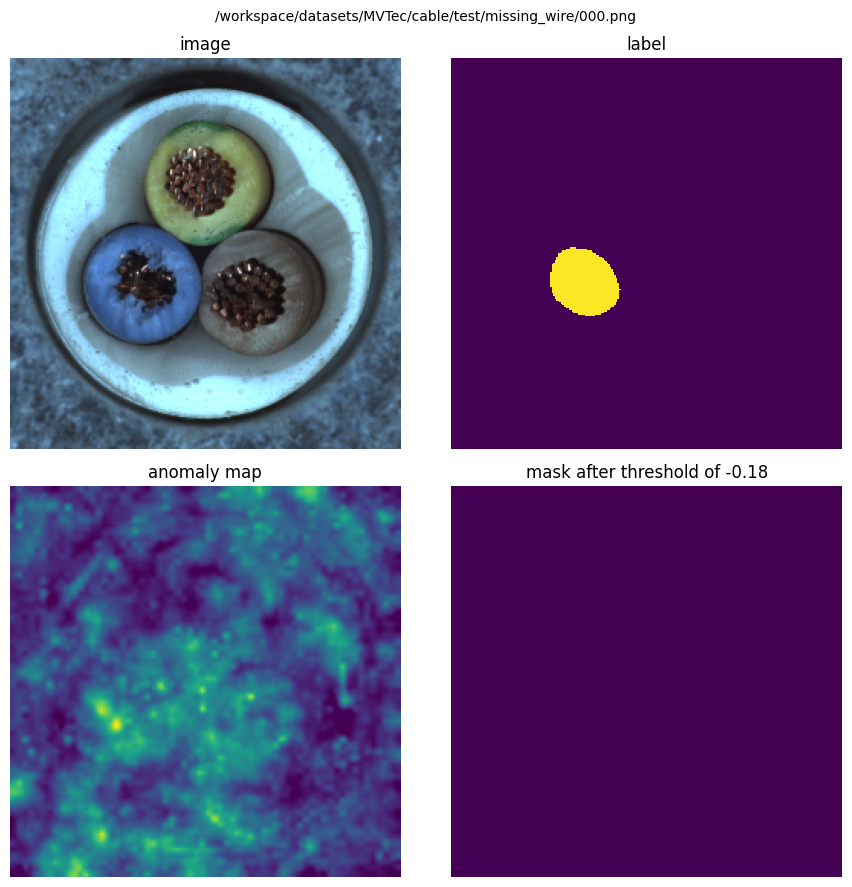

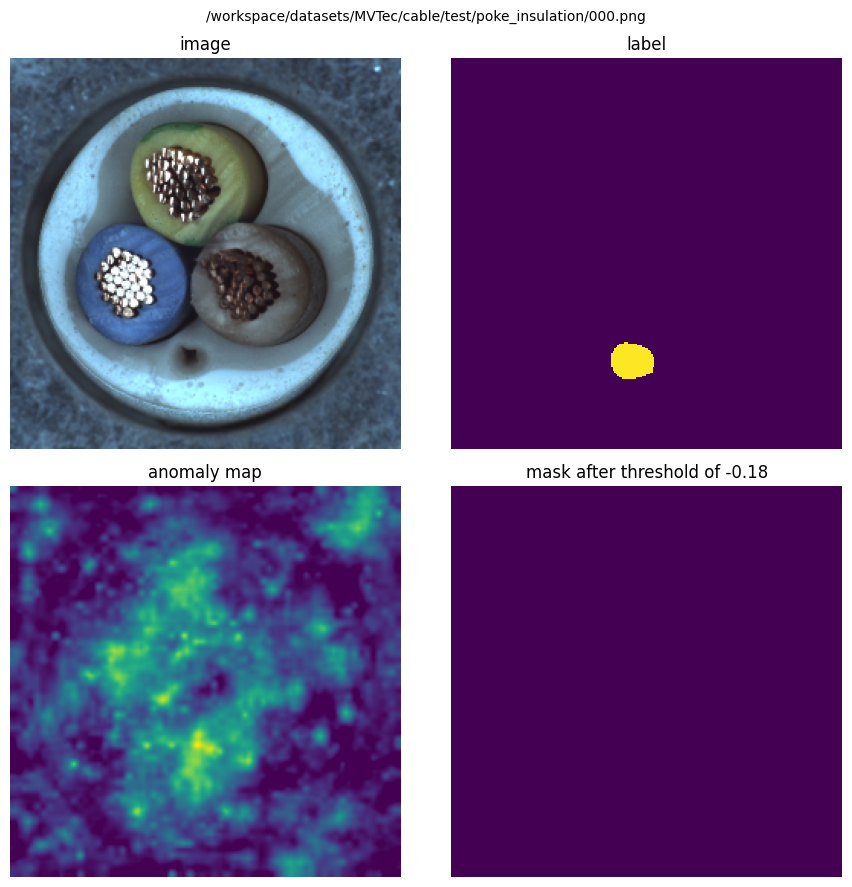

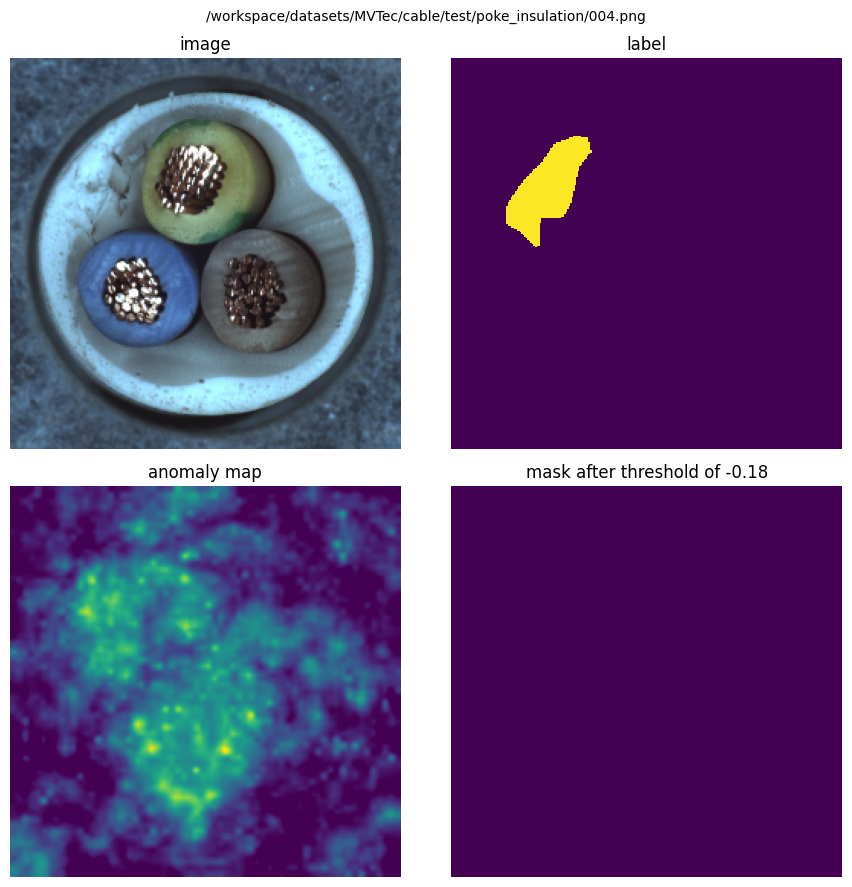

In [48]:
%matplotlib inline

batch_size = len(predictions[0]['image'])
for sample_idx in range(len(datamodule.test_data)):
    label = datamodule.test_data[sample_idx]['label']
    gt = datamodule.test_data[sample_idx]['mask']
    batch_idx = sample_idx // batch_size
    sample_in_batch_idx = sample_idx % batch_size
    pred = predictions[batch_idx]['pred_labels'][sample_in_batch_idx]
    if label > 0 and pred == 0:
        plot_single_prediction_with_gt(gt, predictions, index=sample_idx, threshold=ff.image_threshold.value.cpu().numpy())

## Are all those examples really necessary?

Let's see what happens when the number of training samples is progressively reduced.

### EXERCISE
Plot Precision/Recall/F1Score metrics produced by few experiemnts with (even aggressively) reduced training set. Use FastFlow (default settings) as a model and train each experiment for 5 epochs.

How do you interpret the results? Why the precision is so low compared to the recall?

In [ ]:
# Hint: the Engine can take extra arguments from the PyTorch Lightning library 
# (see here for reference: https://lightning.ai/docs/pytorch/stable/common/trainer.html#limit-train-batches)

L.seed_everything(3210)
training_set_fractions = [0.05, 0.1, 0.2, 0.5, 1.0]

metrics = defaultdict(list)
for training_set_fraction in training_set_fractions:
    engine = Engine(
        image_metrics=image_metrics,
        pixel_metrics=pixel_metrics,
        max_epochs=5,
        check_val_every_n_epoch=5,
        limit_train_batches=training_set_fraction,
    )
    ff = Fastflow()
    engine.fit(model=ff, datamodule=datamodule)
    metrics_i = engine.test(model=ff, datamodule=datamodule)[0]
    for m_name, m_value in metrics_i.items():
        metrics[m_name].append(m_value)

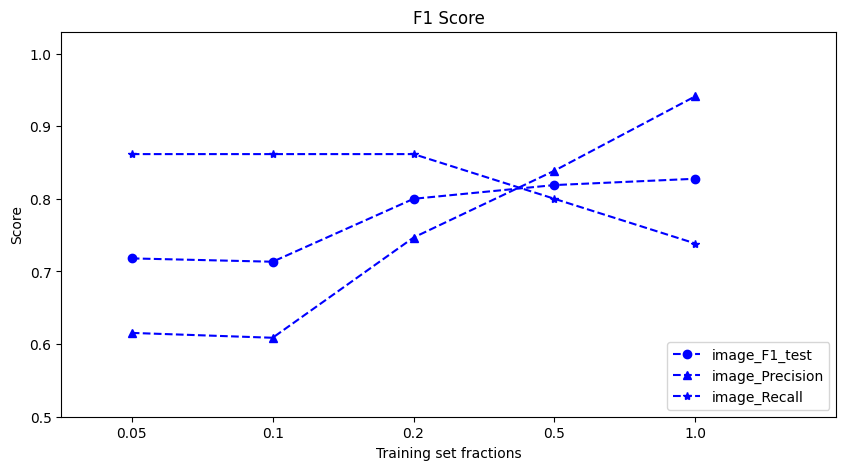

In [50]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,5))
xticks = np.arange(1, len(training_set_fractions) + 1) - 0.5
ax.plot(xticks, metrics['image_F1Score'], "ob--", label="image_F1_test")
ax.plot(xticks, metrics['image_Precision'], "^b--", label="image_Precision")
ax.plot(xticks, metrics['image_Recall'], "*b--", label="image_Recall")
ax.axis((0, 5.5, 0.5, 1.03))
ax.set_title('F1 Score')
ax.set_xticks(ticks=xticks, labels=[f"{i}" for i in training_set_fractions])
ax.set_xlabel("Training set fractions")
ax.set_ylabel('Score')
ax.legend(loc='lower right')
plt.show()

## Data augmentation

As you can see from plots above, having more data can help. However, this is not always possible (either because data do not exist at all or simply because collecting more samples is too expensive). One possibility to mitigate this issue is to "artifically" augment the samples using "augmentation strategies". For example, in our scenario a 90-degree rotated sample is still a valid normal sample and hence it can be added to the training set. As you can easily imagine we could increase the dataset size of a factor of four, by simply adding rotated examples. The same goes for light color corrections (ligher/darker images), geometric transformation etc. As long as your transformed samples are normal you're safe to go.

Pay attention that in some cases augmentations could produce anomalous samples (maybe a rotated cable is considered a defect, this is dependent to the problem definitions/requirements) and they should be avoided.

Until now, default augmentations have been used. These are somehow imposed by the pretrained models used throughout this notebook. However, they can be enriched with extra operations. Augmentations are `torchvision.transforms.v2.Trasnform` objects that are stored as attributes in the dataset. In particular, default augmentations (used so far by for both train/val/test) are
```python
Compose(
      Resize(size=[256], interpolation=InterpolationMode.BILINEAR, antialias=True)
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
)
```
which means that samples are first downscaled (and potentially stretched) to a resolution of 256x256 and then normalized so that pixel values are normally distributed. Obviously, normalization (like also color adjustments) is not applied to labels, but this is handled internally by the dataset. In fact, only geometric transformations are propagated to label masks.

### EXERCISE

Look at the [available augmentations](https://pytorch.org/vision/0.19/transforms.html#v2-api-reference-recommended) and extend the **training** augmentation pipeline. Before running other experiments try to inspect the effect of augmentation by plotting few examples. You might want to disable normalization (or apply a de-norm) in order to get proper color ranges.

Next, take a reduced training set (for instance 10%) and try to improve the metrics by cooking a good training pipeline.

In [ ]:
# Hints:
#  * have a look at how the `AnomalibDataModule` class definition;
#  * actual datasets are initialized during the datamodule `.setup()`
#  * transformation are applied during dataset `__getitem__()`

In [51]:
def show_image_and_mask(datamodule: L.LightningDataModule, index: int | None = None, split: str = "train"):
    if split.startswith("train"):
        dataset = datamodule.train_data
    elif split.startswith("val"):
        dataset = datamodule.val_data
    elif split.startswith("test"):
        dataset = datamodule.test_data
    else:
        raise ValueError("Unknown split")
    
    if index is None:
        index = random.choice(range(len(dataset)))
    sample = dataset[index]
    gt = sample["mask"]
    im = sample["image"]
    # Denormalize
    mean = torch.tensor([[[0.485]], [[0.456]], [[0.406]]])
    std = torch.tensor([[[0.229]], [[0.224]], [[0.225]]])
    im = im * std + mean
    im = (im * 255).to(torch.uint8).permute(1, 2, 0)
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(sample["image_path"], fontsize=10)
    ax[0].imshow(im)
    ax[0].axis("off")
    ax[0].set_title("image")
    ax[1].imshow(gt, interpolation='nearest')
    ax[1].axis("off")
    ax[1].set_title("label")
    plt.tight_layout()
    plt.show()

Compose(
      Resize(size=[256], interpolation=InterpolationMode.BILINEAR, antialias=True)
      RandomRotation(degrees=[-180.0, 180.0], interpolation=InterpolationMode.NEAREST, expand=False, fill=0)
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
      GaussianBlur(kernel_size=(15, 15), sigma=[0.1, 2.0])
)


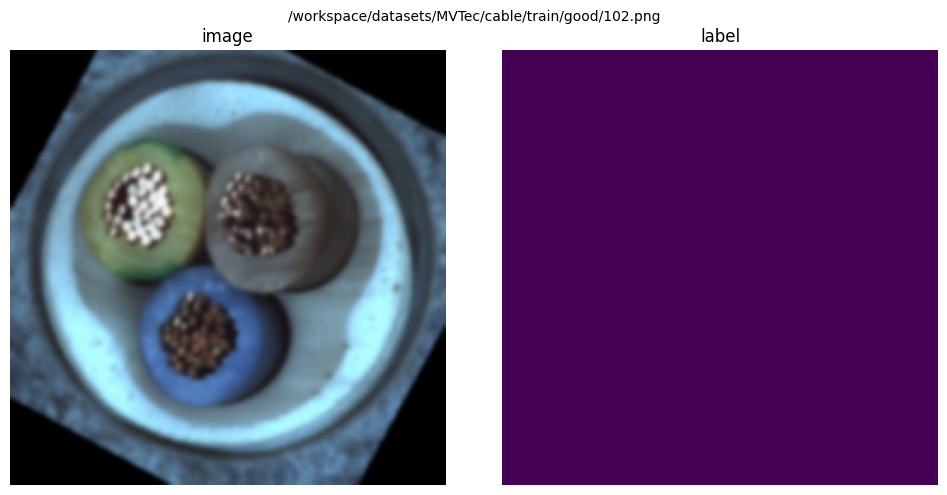

In [75]:
from torchvision.transforms.v2 import ColorJitter, Compose, GaussianBlur, Normalize, RandomRotation, Resize, Transform

transform = Compose(
    [
        Resize(256, antialias=True),
        RandomRotation(180),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        GaussianBlur(15, sigma=(0.1, 2.0)),
    ],
)
datamodule = MVTec(
    category="cable",
    image_size=256,
    train_batch_size=8,
    eval_batch_size=8,
    val_split_ratio=0.3,
    val_split_mode='from_test',
    test_split_ratio=0.3,
    transform=transform,
)
datamodule.prepare_data()
datamodule.setup()
print(datamodule.train_dataloader().dataset.transform)
%matplotlib inline
show_image_and_mask(datamodule, split="train")

## Explore other approaches!
State of the art techniques can get an image F1 Score > 92% on this dataset. Do you have an idea to get close to that value? Anomalib library provides [many models](https://github.com/openvinotoolkit/anomalib/tree/main/src/anomalib/models/image) that are ready-to-use. All of them can be plugged into the _engine_, fitted and tested on the dataset.